<a href="https://www.kaggle.com/code/salilapte/data-mining-comment-classifier?scriptVersionId=218217419" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import re  # For regular expressions in text cleaning
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced visualizations
from sklearn.feature_extraction.text import TfidfVectorizer  # For TF-IDF vectorization
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.linear_model import LogisticRegression  # For Logistic Regression model
from sklearn.model_selection import KFold # For K-Fold model optimization
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)  # For model evaluation metrics

In [2]:
# Describing data
# Load the dataset
df = pd.read_csv('/kaggle/input/test-zencode-ds/file.csv')

print(df.head(5))

# Total entries
print(df.count().sum())

# A brief overview
df.describe()

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Class distribution in 'generated' column
class_distribution = df['label'].value_counts()
print("\nClass Distribution:\n", class_distribution)

# Text length analysis
df['text_length'] = df['texts'].apply(len)
# Summary statistics for text length
text_length_stats = df['text_length'].describe()
print("\nText Length Statistics:\n", text_length_stats)

                                               texts  label
0  "It appears so, mon ami,” said Poirot cautious...      0
1  There was only one diamond, my friend! Origina...      0
2  But I can’t help feeling that it’s rather a fo...      0
3  Pagett left the table half-way through the mea...      0
4  ” The letter was written on a foreign type of ...      0
11690
Missing Values:
 texts    0
label    0
dtype: int64

Class Distribution:
 label
1    2933
0    2912
Name: count, dtype: int64

Text Length Statistics:
 count    5845.000000
mean      572.784431
std        76.539849
min        90.000000
25%       527.000000
50%       576.000000
75%       621.000000
max       821.000000
Name: text_length, dtype: float64


In [3]:
# Data cleaning
# Function to clean text without NLTK
def clean_text_no_nltk(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove simple stopwords manually
    stop_words = {'the', 'and', 'is', 'in', 'to', 'of', 'for', 'it', 'on', 'this', 'that', 'with', 'a', 'as'}
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a cleaned string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply the cleaning function to the 'text' column
df['cleaned_text'] = df['texts'].apply(clean_text_no_nltk)

# Display the first few rows to verify cleaning
print(df[['texts', 'cleaned_text']].head())

                                               texts  \
0  "It appears so, mon ami,” said Poirot cautious...   
1  There was only one diamond, my friend! Origina...   
2  But I can’t help feeling that it’s rather a fo...   
3  Pagett left the table half-way through the mea...   
4  ” The letter was written on a foreign type of ...   

                                        cleaned_text  
0  appears so mon ami said poirot cautiously appe...  
1  there was only one diamond my friend originall...  
2  but i cant help feeling its rather forlorn hop...  
3  pagett left table halfway through meal which a...  
4  letter was written foreign type paper bold cha...  


In [4]:
# Check for missing values
# Handle missing or duplicated entries in the dataset.
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)

# Drop rows with missing values
df = df.dropna()

# Check for duplicate rows
duplicates = df.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicates)

# Drop duplicate rows
df = df.drop_duplicates()


Missing Values:
 texts           0
label           0
text_length     0
cleaned_text    0
dtype: int64

Number of Duplicate Rows: 0


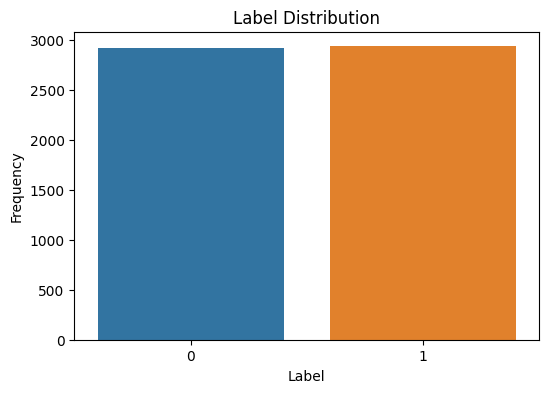

In [5]:
# Plot label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

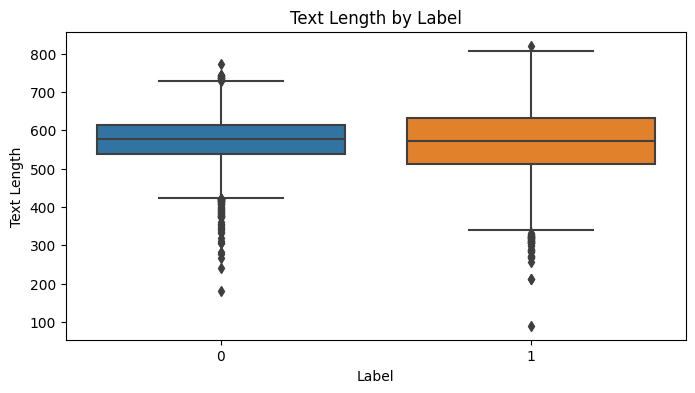

In [6]:
# Boxplot of text length by label
plt.figure(figsize=(8, 4))
sns.boxplot(x='label', y='text_length', data=df)
plt.title("Text Length by Label")
plt.xlabel("Label")
plt.ylabel("Text Length")
plt.show()

   text_length  word_count  avg_word_length
0          558          96         4.822917
1          485          85         4.717647
2          512          94         4.457447
3          443          81         4.481481
4          430          77         4.597403


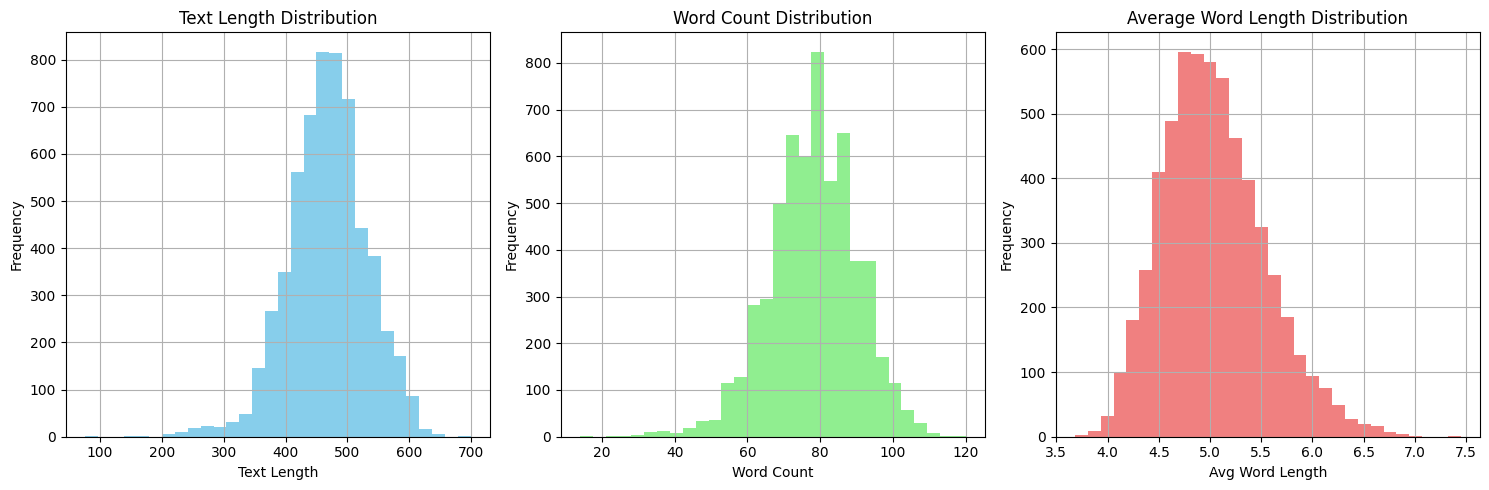

In [7]:
# Text length features
df['text_length'] = df['cleaned_text'].apply(len)
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['cleaned_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)

# Display the new features
print(df[['text_length', 'word_count', 'avg_word_length']].head())

# Plot histograms for each feature
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['text_length'].hist(bins=30, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
df['word_count'].hist(bins=30, color='lightgreen')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
df['avg_word_length'].hist(bins=30, color='lightcoral')
plt.title('Average Word Length Distribution')
plt.xlabel('Avg Word Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


TF-IDF Features (Unigrams and Bigrams):
       about  absolutely  across     after  again  against        ah       air  \
0  0.000000         0.0     0.0  0.105249    0.0      0.0  0.000000  0.000000   
1  0.098622         0.0     0.0  0.000000    0.0      0.0  0.151556  0.178866   
2  0.000000         0.0     0.0  0.000000    0.0      0.0  0.000000  0.000000   
3  0.000000         0.0     0.0  0.000000    0.0      0.0  0.000000  0.000000   
4  0.000000         0.0     0.0  0.000000    0.0      0.0  0.000000  0.000000   

        all  almost  ...  you see  you think  you were  you will  young  \
0  0.000000     0.0  ...      0.0    0.00000       0.0       0.0    0.0   
1  0.000000     0.0  ...      0.0    0.00000       0.0       0.0    0.0   
2  0.000000     0.0  ...      0.0    0.15012       0.0       0.0    0.0   
3  0.000000     0.0  ...      0.0    0.00000       0.0       0.0    0.0   
4  0.096583     0.0  ...      0.0    0.00000       0.0       0.0    0.0   

   young man     you

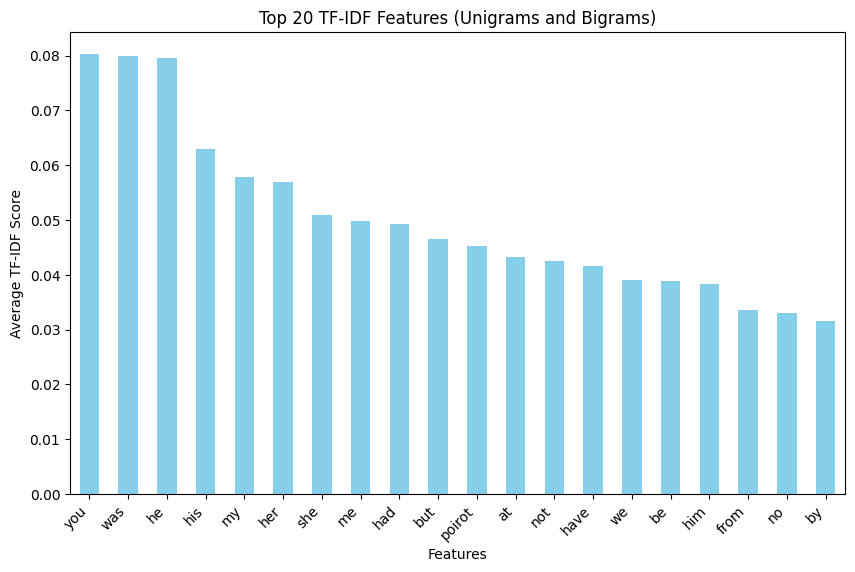

In [8]:
# TF-IDF Vectorization
# Extracting unigrams and bigrams using TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Convert the TF-IDF matrix to a DataFrame for easier interpretation
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the top features (unigrams and bigrams)
print("\nTF-IDF Features (Unigrams and Bigrams):\n", tfidf_df.head())

# Compute the average TF-IDF score for each feature
tfidf_mean = tfidf_df.mean().sort_values(ascending=False)

# Select the top 20 features
top_features = tfidf_mean.head(20)

# Plot the top features
plt.figure(figsize=(10, 6))
top_features.plot(kind='bar', color='skyblue')
plt.title('Top 20 TF-IDF Features (Unigrams and Bigrams)')
plt.ylabel('Average TF-IDF Score')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.show()

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000)  # Reduce features for efficiency
X = vectorizer.fit_transform(df['texts'])
y = df['label']

Logistic Regression Accuracy: 0.932420872540633
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       604
           1       0.93      0.93      0.93       565

    accuracy                           0.93      1169
   macro avg       0.93      0.93      0.93      1169
weighted avg       0.93      0.93      0.93      1169

Accuracy with Heuristic Fix: 0.853721129170231
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       604
           1       0.78      0.96      0.86       565

    accuracy                           0.85      1169
   macro avg       0.87      0.86      0.85      1169
weighted avg       0.87      0.85      0.85      1169



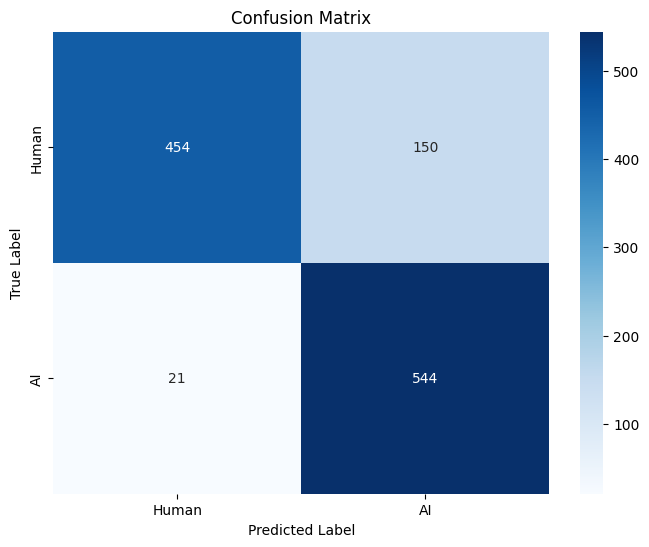

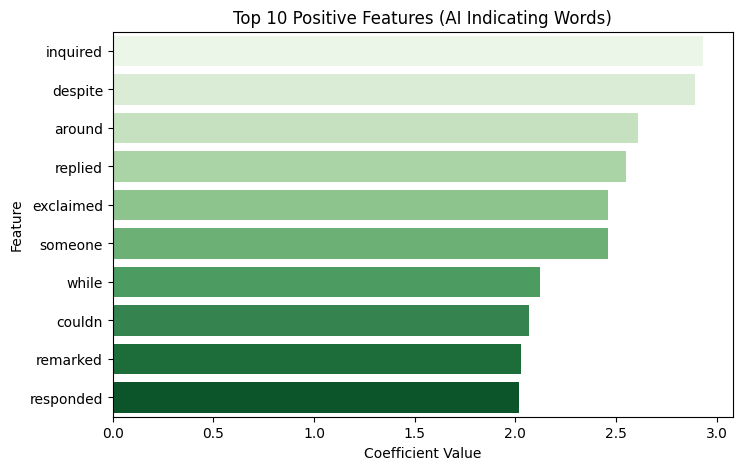

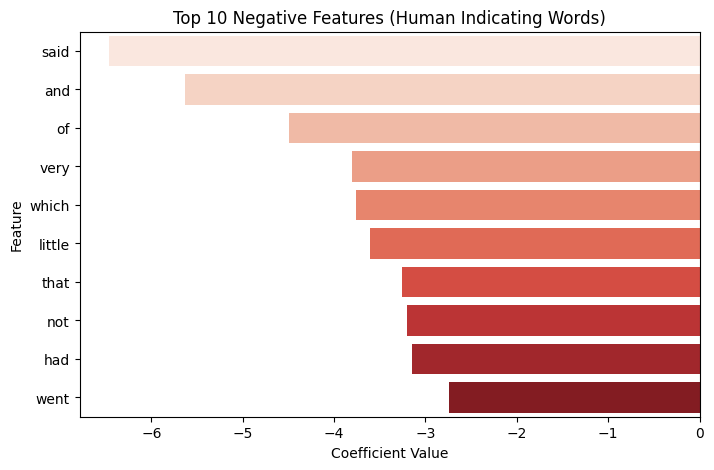

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


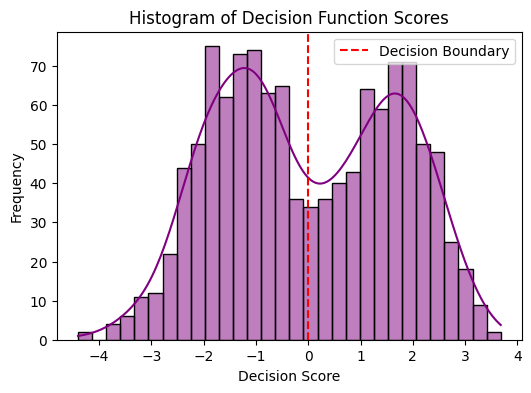

In [9]:
# Base Model Training using Logistic Regression
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
log_model = LogisticRegression(max_iter=1000, solver='liblinear')  # Ensure solver compatibility
log_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = log_model.predict(X_test)
y_score = log_model.decision_function(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Enhanced preprocessing function
def clean_text_enhanced(text):
    text = text.lower()
    # Remove only special characters, but keep punctuation
    text = re.sub(r'[^a-z\s.,;:!?]', '', text)
    return text

# Heuristic fix function
def heuristic_fix(text, prediction):
    human_keywords = ['virtue', 'nation', 'manly', 'citizen', 'flag', 'freedom']
    if sum(word in text.lower() for word in human_keywords) >= 3:
        return 0  # Bias towards "Human"
    return prediction

# Prediction and evaluation with heuristic fix
def predict_with_heuristic(input_text):
    cleaned_text = clean_text_enhanced(input_text)
    vectorized_text = vectorizer.transform([cleaned_text])
    raw_prediction = log_model.predict(vectorized_text)[0]
    return heuristic_fix(input_text, raw_prediction)

# Evaluate on test data
y_pred = []
for text in X_test:
    raw_text = vectorizer.inverse_transform(text)[0]  # Extract raw text from the vectorized input
    y_pred.append(predict_with_heuristic(' '.join(raw_text)))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Heuristic Fix: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get coefficients from the logistic regression model
coefficients = log_model.coef_[0]

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Combine features and coefficients into a DataFrame
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Display top positive and negative coefficients
top_positive = coef_df.nlargest(10, 'Coefficient')
top_negative = coef_df.nsmallest(10, 'Coefficient')

# Plot top positive coefficients
plt.figure(figsize=(8, 5))
sns.barplot(x='Coefficient', y='Feature', data=top_positive, palette='Greens')
plt.title('Top 10 Positive Features (AI Indicating Words)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Plot top negative coefficients
plt.figure(figsize=(8, 5))
sns.barplot(x='Coefficient', y='Feature', data=top_negative, palette='Reds')
plt.title('Top 10 Negative Features (Human Indicating Words)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# **Visualization 5: Histogram of Predictions**
plt.figure(figsize=(6, 4))
sns.histplot(y_score, kde=True, bins=30, color='purple')
plt.axvline(0, color='red', linestyle='--', label='Decision Boundary')
plt.title('Histogram of Decision Function Scores')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [10]:
# Linear regression
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ensure your dataset has the necessary columns
# Replace 'text_column' and 'label_column' with actual column names
text_column = 'texts'  # Replace with the column containing text data
label_column = 'label'  # Replace with the column containing labels (e.g., 0 for human, 1 for AI)

# Check for null values and clean the data
df = df.dropna(subset=[text_column, label_column])

# Step 2: Feature Extraction
# Use TF-IDF to convert text to numerical features
vectorizer = TfidfVectorizer(max_features=500)  # Adjust max_features if needed
X = vectorizer.fit_transform(df[text_column]).toarray()
y = df[label_column]

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Predictions
# Linear regression outputs continuous values, so apply a threshold
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Step 6: Evaluation
accuracy = accuracy_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
report = classification_report(y_test, y_pred_binary)

# Print results
print("Linear Regression Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

Linear Regression Accuracy: 0.8964927288280582

Confusion Matrix:
 [[547  57]
 [ 64 501]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90       604
           1       0.90      0.89      0.89       565

    accuracy                           0.90      1169
   macro avg       0.90      0.90      0.90      1169
weighted avg       0.90      0.90      0.90      1169



In [11]:
# Shallow Neural Network (MLP)
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Ensure your dataset has the required columns
text_column = 'texts'  # Replace with your text column
label_column = 'label'  # Replace with your label column (0 for human, 1 for AI)

# Drop null values
df = df.dropna(subset=[text_column, label_column])

# Step 2: Preprocess Text Data
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Limit features for efficiency
X = vectorizer.fit_transform(df[text_column]).toarray()
y = df[label_column].values

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Build the Neural Network Model
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),  # Input layer
    Dropout(0.5),  # Dropout for regularization
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Step 5: Train the Model
# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Step 6: Evaluate the Model
y_pred_probs = model.predict(X_test).flatten()  # Predicted probabilities
y_pred = (y_pred_probs >= 0.5).astype(int)  # Threshold at 0.5 for binary classification

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f" Shallow Neural Network (MLP) Accuracy: {accuracy}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 7: Save the Model and Vectorizer (Optional for Kaggle Submission)
model.save('/kaggle/working/shallow_nn_model.h5')

import pickle
with open('/kaggle/working/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("Model and vectorizer saved!")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5636 - loss: 0.6751 - val_accuracy: 0.8996 - val_loss: 0.3778
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9120 - loss: 0.2869 - val_accuracy: 0.9316 - val_loss: 0.2036
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9540 - loss: 0.1439 - val_accuracy: 0.9338 - val_loss: 0.1984
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9700 - loss: 0.1062 - val_accuracy: 0.9284 - val_loss: 0.2087
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9757 - loss: 0.0779 - val_accuracy: 0.9295 - val_loss: 0.2255
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9850 - loss: 0.0607 - val_accuracy: 0.9231 - val_loss: 0.2459
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 Shallow Neural Network (MLP) Accuracy: 0.9298545765611634

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       604


In [12]:
# Naive Bayes
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensure your dataset has the required columns
text_column = 'texts'  # Replace with your text column
label_column = 'label'  # Replace with your label column (0 for human, 1 for AI)

# Drop null values
df = df.dropna(subset=[text_column, label_column])

# Step 2: Preprocess Text Data
# Use TF-IDF to convert text to numerical features
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(df[text_column])
y = df[label_column]

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Step 5: Make Predictions
y_pred = nb_model.predict(X_test)

# Step 6: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Naive Bayes Accuracy: {accuracy}\n")
print(f"Confusion Matrix:\n{conf_matrix}\n")
print(f"Classification Report:\n{report}\n")

# Step 7: Save the Model and Vectorizer (Optional for Kaggle Submission)
import pickle
with open('/kaggle/working/naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)

with open('/kaggle/working/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("Model and vectorizer saved!")

Naive Bayes Accuracy: 0.951240376390077

Confusion Matrix:
[[601   3]
 [ 54 511]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.95       604
           1       0.99      0.90      0.95       565

    accuracy                           0.95      1169
   macro avg       0.96      0.95      0.95      1169
weighted avg       0.95      0.95      0.95      1169


Model and vectorizer saved!


In [13]:
# Convolutional Neural Network (CNN)
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Ensure your dataset has the required columns
text_column = 'texts'  # Replace with your text column
label_column = 'label'  # Replace with your label column (0 for human, 1 for AI)

# Drop null values
df = df.dropna(subset=[text_column, label_column])

# Encode labels if they are not numeric
if df[label_column].dtype == 'object':
    encoder = LabelEncoder()
    df[label_column] = encoder.fit_transform(df[label_column])

# Step 2: Preprocess Text Data
# Tokenize the text
max_vocab_size = 20000  # Adjust the vocabulary size as needed
max_sequence_length = 100  # Adjust based on the average sentence length in your dataset

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(df[text_column])
X = tokenizer.texts_to_sequences(df[text_column])
X = pad_sequences(X, maxlen=max_sequence_length)

# Extract labels
y = df[label_column].values

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Build the CNN Model
embedding_dim = 50  # Size of the word embeddings
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Conv1D(128, 5, activation='relu'),  # 128 filters, kernel size 5
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Step 6: Evaluate the Model
results = model.evaluate(X_test, y_test, verbose=0)
print(f"CNN Test Accuracy: {results[1]}")

# Step 7: Save the Model and Tokenizer
model.save('/kaggle/working/cnn_text_classifier.h5')

import pickle
with open('/kaggle/working/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Model and tokenizer saved!")

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6072 - loss: 0.6550 - val_accuracy: 0.7511 - val_loss: 0.5128
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7817 - loss: 0.4687 - val_accuracy: 0.8996 - val_loss: 0.2566
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9550 - loss: 0.1573 - val_accuracy: 0.9231 - val_loss: 0.2210
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9880 - loss: 0.0484 - val_accuracy: 0.9263 - val_loss: 0.2154
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9959 - loss: 0.0208 - val_accuracy: 0.9231 - val_loss: 0.2420
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9956 - loss: 0.0208 - val_accuracy: 0.9263 - val_loss: 0.2581
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9986 - loss: 0.0109 - val_accuracy: 0.9274 - val_loss: 0.2886
CNN Test Accuracy: 0.9503849148750305
Model and tokenizer saved!


In [14]:
# Gradient Boosting
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensure your dataset has the required columns
text_column = 'texts'  # Replace with your text column
label_column = 'label'  # Replace with your label column (0 for human, 1 for AI)

# Drop null values
df = df.dropna(subset=[text_column, label_column])

# Step 2: Preprocess Text Data
# Use TF-IDF to convert text to numerical features
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(df[text_column]).toarray()
y = df[label_column]

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the Gradient Boosting Model
# Instantiate and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Step 5: Make Predictions
y_pred = gb_model.predict(X_test)

# Step 6: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}\n")
print(f"Confusion Matrix:\n{conf_matrix}\n")
print(f"Classification Report:\n{report}\n")

# Step 7: Save the Model and Vectorizer (Optional for Kaggle Submission)
import pickle
with open('/kaggle/working/gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(gb_model, f)

with open('/kaggle/working/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("Model and vectorizer saved!")

Accuracy: 0.8768177929854577

Confusion Matrix:
[[524  80]
 [ 64 501]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       604
           1       0.86      0.89      0.87       565

    accuracy                           0.88      1169
   macro avg       0.88      0.88      0.88      1169
weighted avg       0.88      0.88      0.88      1169


Model and vectorizer saved!


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.9523097490744549

Classification Report for Optimized Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       604
           1       0.95      0.94      0.95       565

    accuracy                           0.95      1169
   macro avg       0.95      0.95      0.95      1169
weighted avg       0.95      0.95      0.95      1169



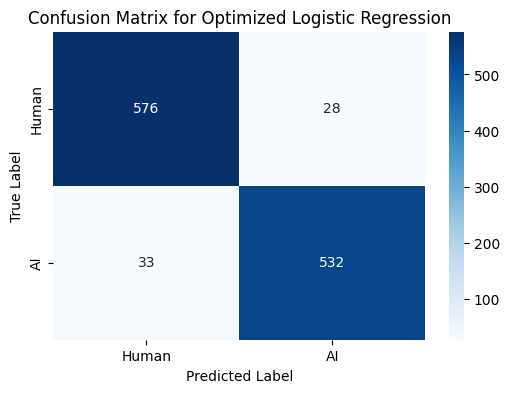

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'text' is the feature column and 'generated' is the target column
X_raw = df['texts']
y = df['label']

# Convert text to numeric features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(X_raw)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'penalty': ['l2'],  # L2 regularization
    'solver': ['liblinear'],  # Solver compatible with L2
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Display the best parameters and cross-validation score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report for Optimized Logistic Regression:")
print(classification_report(y_test, y_pred, zero_division=0))

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.title('Confusion Matrix for Optimized Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

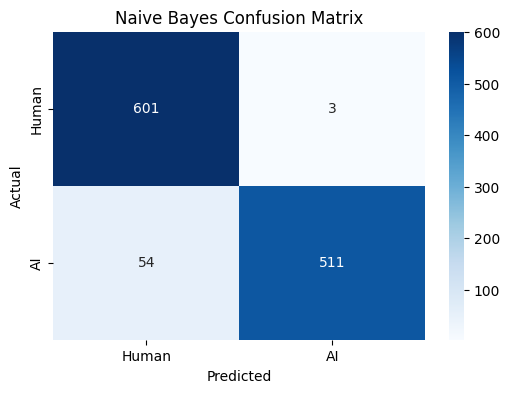

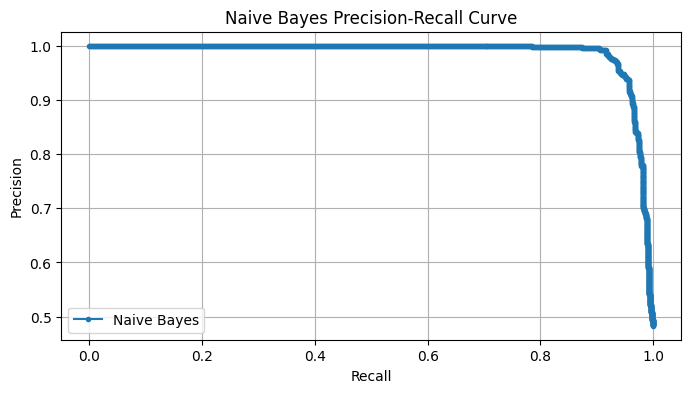

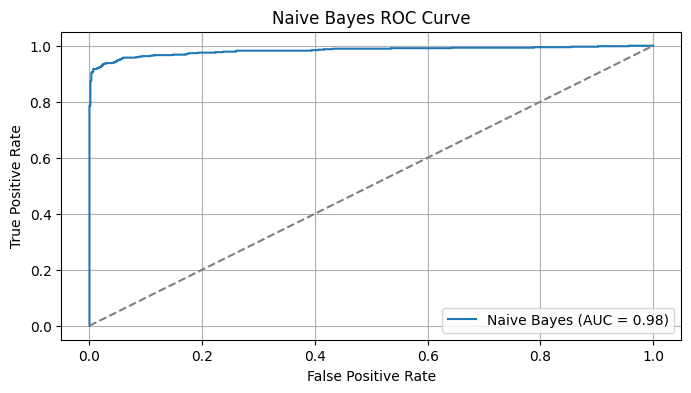

In [16]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

def visualize_naive_bayes(y_test, y_pred, y_pred_proba):
    # 1. Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
    plt.title("Naive Bayes Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # 2. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 4))
    plt.plot(recall, precision, marker='.', label='Naive Bayes')
    plt.title("Naive Bayes Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 4))
    plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title("Naive Bayes ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Usage:
# Assuming y_test, y_pred, and y_pred_proba are obtained from the trained Naive Bayes model

# 1. Predict labels and probabilities
y_pred = nb_model.predict(X_test)  # Predicted labels
y_pred_proba = nb_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# 2. Call the visualization function
visualize_naive_bayes(y_test, y_pred, y_pred_proba)

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step


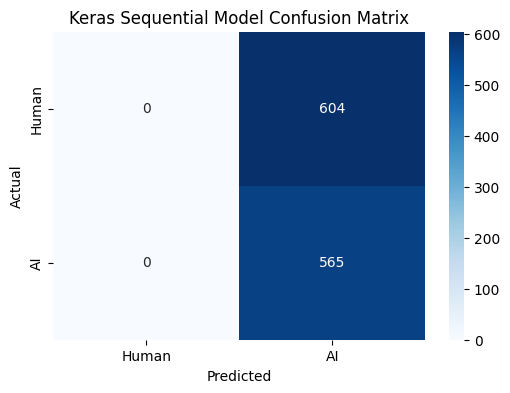

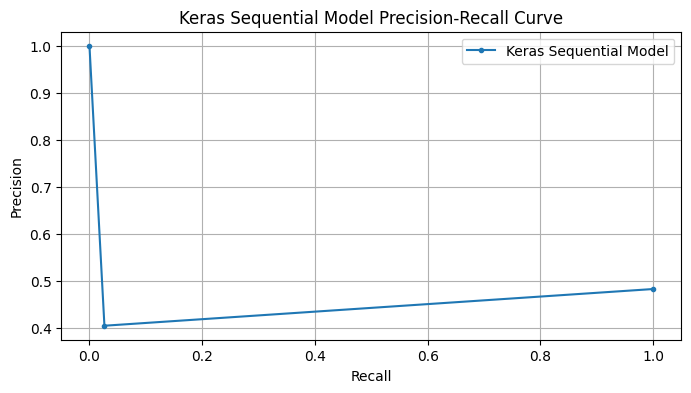

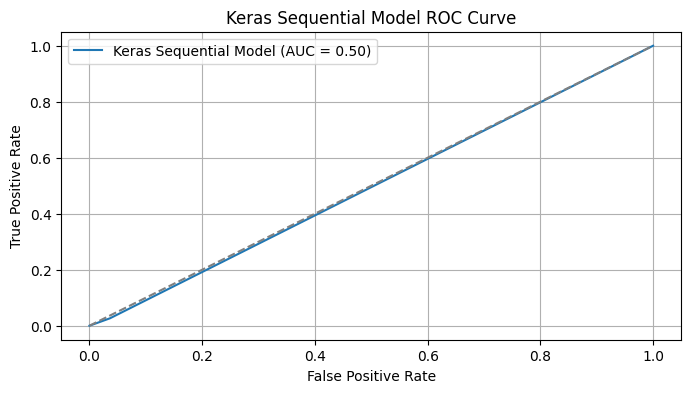

[CV 3/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.926 total time=   0.0s
[CV 3/5] END C=10, penalty=l2, solver=liblinear;, score=0.957 total time=   0.1s
[CV 4/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.909 total time=   0.0s
[CV 2/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.908 total time=   0.0s
[CV 5/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.909 total time=   0.0s
[CV 1/5] END .C=1, penalty=l2, solver=liblinear;, score=0.939 total time=   0.1s
[CV 2/5] END .C=1, penalty=l2, solver=liblinear;, score=0.943 total time=   0.1s
[CV 3/5] END .C=1, penalty=l2, solver=liblinear;, score=0.957 total time=   0.1s
[CV 4/5] END .C=1, penalty=l2, solver=liblinear;, score=0.951 total time=   0.1s
[CV 5/5] END .C=1, penalty=l2, solver=liblinear;, score=0.936 total time=   0.1s
[CV 1/5] END C=10, penalty=l2, solver=liblinear;, score=0.952 total time=   0.1s
[CV 4/5] END C=10, penalty=l2, solver=liblinear;, score=0.958 total time=   0.1s
[CV 1/5] END C=0.1, pena

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

def visualize_keras_model(model, X_test, y_test, y_pred, y_pred_proba, model_name="Keras Model"):
    # 1. Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # 2. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 4))
    plt.plot(recall, precision, marker='.', label=model_name)
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 4))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f"{model_name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Usage:
# Assuming model, X_test, y_test, y_pred, and y_pred_proba are available
# Predict probabilities for the positive class
# 1. Predict probabilities using Keras model
y_pred_proba = model.predict(X_test).flatten()  # Ensure output is 1D array

# 2. Convert probabilities to binary predictions using a threshold
y_pred = (y_pred_proba >= 0.5).astype(int)

# 3. Visualize results
visualize_keras_model(model, X_test, y_test, y_pred, y_pred_proba, model_name="Keras Sequential Model")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualization for Linear Regression
def visualize_linear_regression(y_test, y_pred, model_name="Linear Regression"):
    # Confusion Matrix
    y_pred_binary = (y_pred >= 0.5).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_binary)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Visualization for CNN and SNN (Accuracy and Loss)
def visualize_cnn_snn(history, model_name="CNN/SNN"):
    # Accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Loss
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_linear_regression(y_test, y_pred)
# For CNN or SNN
# Assume `history` is the training history returned by the `fit()` function
visualize_cnn_snn(history, model_name="SNN")
visualize_cnn_snn(history, model_name="CNN")

In [ ]:
from sklearn.manifold import TSNE
# Apply the cleaning function to the 'text' column
df['cleaned_text'] = df['texts'].apply(clean_text_no_nltk)
df.head()
df_subset = df[:10000]
# Extract the text and target columns
X_raw = df_subset['cleaned_text']
y = df_subset['label']

# Convert text to numeric features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(X_raw)
# Apply t-SNE to reduce the dimensionality of the data
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
X_tsne = tsne.fit_transform(X.toarray())  # Converting sparse matrix to dense array

# Create a DataFrame with the t-SNE results
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = y
# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['label'], cmap='viridis', alpha=0.5)
plt.title('t-SNE visualization of text data')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.colorbar(label='Generated (AI or Human)')
plt.show()

In [ ]:
# Generates .pkl files that can be used for local UI demo of the trained model
import pickle

# Save the trained Logistic Regression model
with open("log_model.pkl", "wb") as model_file:
    pickle.dump(log_model, model_file)

# Save the trained TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)